## CUDA and SPLIT


In [1]:
from torch.utils.data import DataLoader
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
SPLIT_BY = 'arb'

## Calculate Normalization Vectors

In [2]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset
from torch.utils.data import DataLoader

class StatsRecorder:
    def __init__(self, red_dims=(0,1,2)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            if data.shape[1] != self.ndimensions:
                raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n


root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/1d-cnn/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=8, shuffle=True)

# create recorders
global_stats  = StatsRecorder()
channel_stats = StatsRecorder(red_dims=(0,1))

# step through the training dataset
with torch.no_grad():
    
    for idx,(x,y) in enumerate(iter(train_dataloader)):
        # print(x.shape)
        # print((torch.mean(x, axis=1)))
        # update normalization statistics
        # x=(x-torch.mean(x))/torch.std(x)
        global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
global_mean,global_std = global_stats.mean,global_stats.std
global_mean=global_mean.squeeze(0)
global_std=global_std.squeeze(0)


channel_mean,channel_std = channel_stats.mean,channel_stats.std
channel_mean=channel_mean.squeeze(0)
channel_std=channel_std.squeeze(0)

print(f'Shape of global mean: {global_mean.shape}')
print(f'Shape of global standard dev: {global_std.shape}')

print(f'Shape of channel mean: {channel_mean.shape}')
print(f'Shape of channel standard dev: {channel_std.shape}')
# print(channel_mean)
global_mean.to(DEVICE)
global_std.to(DEVICE)

channel_mean.to(DEVICE)
channel_std.to(DEVICE)

# print(channel_std)
pass


Shape of global mean: torch.Size([1, 1])
Shape of global standard dev: torch.Size([1, 1])
Shape of channel mean: torch.Size([1, 186])
Shape of channel standard dev: torch.Size([1, 186])


## check sample

torch.Size([16, 1, 186])
tensor(-0.1768, device='cuda:0')


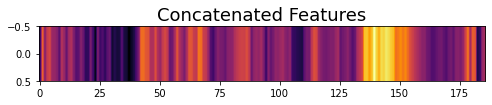

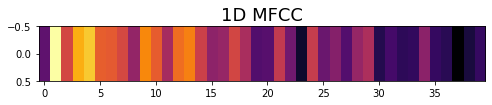

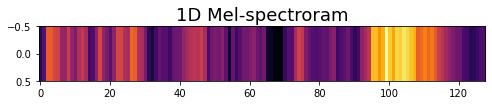

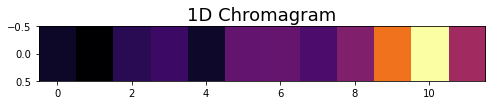

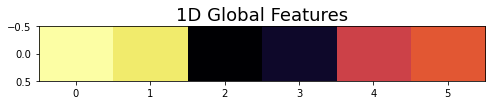

In [13]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/1d-cnn/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=channel_mean, std= channel_std)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=16, shuffle=False)


imput_dim=(None,None)

for src, tgt in train_dataloader:
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)
    
    print(src.shape)
    
    imput_dim=(src.shape[1], src.shape[2])
#     print(tgt.shape)
#     print(torch.mean(src, axis=1).shape)
    

    print(torch.mean(src[0][0]))
    fig=plt.figure(figsize=(8,1))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("Concatenated Features", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    fig=plt.figure(figsize=(8,1))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("1D MFCC", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,:40], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    fig=plt.figure(figsize=(8,1))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("1D Mel-spectroram", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,40:168], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    
    fig=plt.figure(figsize=(8,1))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("1D Chromagram", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,168:180], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    
    fig=plt.figure(figsize=(8,1))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("1D Global Features", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,180:], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    # print(std)
    # print(src.cpu().numpy()[5])

    break
    
    





## Train Eval functions

In [4]:

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/1d-cnn/'

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
#         if(NORM=='channel'):
#             mean=channel_mean.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
#             std=channel_std.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
        
#         elif NORM == 'global':
#             mean=global_mean.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
#             std=global_std.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
            
#         else:
#             mean=torch.tensor(0).to(DEVICE)
#             std=torch.tensor(1).to(DEVICE)
            
#         # src=(src-torch.mean(src, axis=1))/torch.std(src, axis=1)
#         src_norm=(src-mean)/std
        
        logits = model(src)
        # print(logits.shape)

        optimizer.zero_grad()
        
       

        loss = loss_fn(logits, tgt)
        # print(loss)
        # loss = loss_fn(logits, tgt_out)

        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    
    val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
#         if NORM=='channel':
#             mean=channel_mean.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
#             std=channel_std.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
        
#         elif NORM == 'global':
#             mean=global_mean.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
#             std=global_std.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
            
#         else:
#             mean=torch.tensor(0).to(DEVICE)
#             std=torch.tensor(1).to(DEVICE)
            
#         # src=(src-torch.mean(src))/torch.std(src)
#         src_norm=(src-mean)/std

        logits = model(src)
  
        loss = loss_fn(logits, tgt)
     
        losses += loss.item()
    
    
    
    return losses / len(val_dataloader)



def train_deploy_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = RAVDESSFeatureDataset(split='train_all',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
        
        logits = model(src)
        # print(logits.shape)

        optimizer.zero_grad()
        
       

        loss = loss_fn(logits, tgt)
        # print(loss)
        # loss = loss_fn(logits, tgt_out)

        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)

# MLP

In [5]:


class Ravdess_MLP(nn.Module):

    def __init__(self, input_size, tgt_class_cnt, num_of_layers):
        super(Ravdess_MLP, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        self.hidden_dim=input_size*4#int(self.input_size/2)
                               
        self.linear_relu_stack1 = nn.Sequential(

           
            nn.Linear(input_size, int(self.hidden_dim/2)),
            nn.BatchNorm1d(int(self.hidden_dim/2)),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(int(self.hidden_dim/2), self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            # nn.Dropout(0.1),
        )
        
#         self.hidden = []
#         for k in range(num_of_layers):
#             self.hidden.append(nn.Linear(self.hidden_dim, self.hidden_dim))
#             self.hidden.append(nn.BatchNorm1d(self.hidden_dim))
#             self.hidden.append(nn.ReLU())
#             # self.hidden.append(nn.Dropout(0.1))


#         self.linear_relu_stack2 = nn.Sequential(*self.hidden)
        
        self.linear_relu_stack3 = nn.Sequential(
  
            # nn.Linear(self.hidden_dim, int(self.hidden_dim)),
            # nn.BatchNorm1d(int(self.hidden_dim)),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(int(self.hidden_dim), int(self.hidden_dim/2)),
            nn.BatchNorm1d(int(self.hidden_dim/2)),
            nn.ReLU(),
            nn.Dropout(0.2),
            
#             nn.Linear(int(self.hidden_dim/4), int(self.hidden_dim/8)),
#             nn.BatchNorm1d(int(self.hidden_dim/8)),
#             nn.ReLU(),
            # nn.Dropout(0.1),
            
            nn.Linear(int(self.hidden_dim/2), tgt_class_cnt)
  
#             nn.Dropout(0.5),
           

        )
   
    def forward(self, x):
       
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.linear_relu_stack1(x)
        # x = self.linear_relu_stack2(x)
        x = self.linear_relu_stack3(x)
        

        return x




In [6]:
from torchsummary import summary

INPUT_SIZE=imput_dim[0]*imput_dim[1]
TGT_CLASS_CNT=8

lr=0.0001
betas=(0.9, 0.98)
eps=1e-9

mlp = Ravdess_MLP(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT, num_of_layers=2)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(mlp)
print(mlp)
for p in mlp.parameters():
    if p.dim() > 1:
        nn.init.kaiming_uniform_(p)

mlp = mlp.to(DEVICE)

# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, betas=betas, eps=eps)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       69,564
|    └─BatchNorm1d: 2-2                  744
|    └─ReLU: 2-3                         --
|    └─Linear: 2-4                       277,512
|    └─BatchNorm1d: 2-5                  1,488
|    └─ReLU: 2-6                         --
|    └─Dropout: 2-7                      --
|    └─Linear: 2-8                       554,280
|    └─BatchNorm1d: 2-9                  1,488
|    └─ReLU: 2-10                        --
├─Sequential: 1-2                        --
|    └─Linear: 2-11                      277,140
|    └─BatchNorm1d: 2-12                 744
|    └─ReLU: 2-13                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      2,984
Total params: 1,185,944
Trainable params: 1,185,944
Non-trainable params: 0
Ravdess_MLP(
  (linear_relu_stack1): Sequential(
    (0): Linear(in_features=186, out_features=37

In [7]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 60
NORM=None#'channel'
BATCH_SIZE = 8 #128

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": lr, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(mlp, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(mlp, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(mlp)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
    

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



wandb: Currently logged in as: mohnik (use `wandb login --relogin` to force relogin)


Epoch: 1, Train loss: 2.231, Val loss: 1.732, Epoch time = 0.864s
Epoch: 2, Train loss: 1.975, Val loss: 1.655, Epoch time = 0.823s
Epoch: 3, Train loss: 1.781, Val loss: 1.551, Epoch time = 0.782s
Epoch: 4, Train loss: 1.746, Val loss: 1.533, Epoch time = 0.819s
Epoch: 5, Train loss: 1.630, Val loss: 1.473, Epoch time = 0.835s
Epoch: 6, Train loss: 1.610, Val loss: 1.446, Epoch time = 0.808s
Epoch: 7, Train loss: 1.497, Val loss: 1.384, Epoch time = 0.785s
Epoch: 8, Train loss: 1.448, Val loss: 1.349, Epoch time = 0.818s
Epoch: 9, Train loss: 1.460, Val loss: 1.358, Epoch time = 0.814s
Epoch: 10, Train loss: 1.406, Val loss: 1.295, Epoch time = 0.783s
Epoch: 11, Train loss: 1.409, Val loss: 1.236, Epoch time = 0.759s
Epoch: 12, Train loss: 1.340, Val loss: 1.217, Epoch time = 0.801s
Epoch: 13, Train loss: 1.330, Val loss: 1.240, Epoch time = 0.769s
Epoch: 14, Train loss: 1.254, Val loss: 1.217, Epoch time = 0.762s
Epoch: 15, Train loss: 1.219, Val loss: 1.227, Epoch time = 0.769s
Epoc

## train validation performance

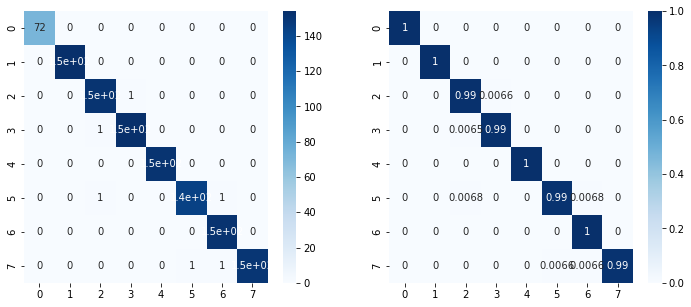

train
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        72
           1      1.000     1.000     1.000       154
           2      0.987     0.993     0.990       152
           3      0.994     0.994     0.994       155
           4      1.000     1.000     1.000       151
           5      0.993     0.986     0.990       146
           6      0.987     1.000     0.993       152
           7      1.000     0.987     0.993       152

    accuracy                          0.995      1134
   macro avg      0.995     0.995     0.995      1134
weighted avg      0.995     0.995     0.995      1134



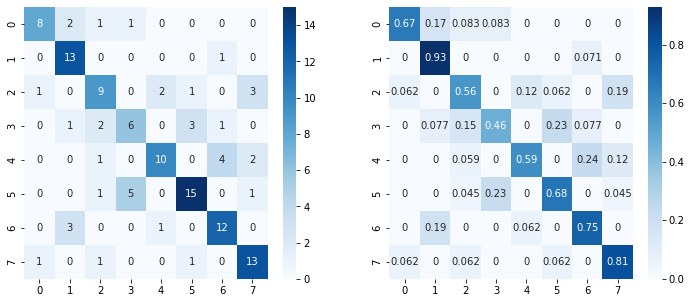

validation
              precision    recall  f1-score   support

           0      0.800     0.667     0.727        12
           1      0.684     0.929     0.788        14
           2      0.600     0.562     0.581        16
           3      0.500     0.462     0.480        13
           4      0.769     0.588     0.667        17
           5      0.750     0.682     0.714        22
           6      0.667     0.750     0.706        16
           7      0.684     0.812     0.743        16

    accuracy                          0.683       126
   macro avg      0.682     0.681     0.676       126
weighted avg      0.686     0.683     0.679       126



/home/spongebob*/anaconda3/envs/irl_nik/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spongebob*/anaconda3/envs/irl_nik/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spongebob*/anaconda3/envs/irl_nik/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

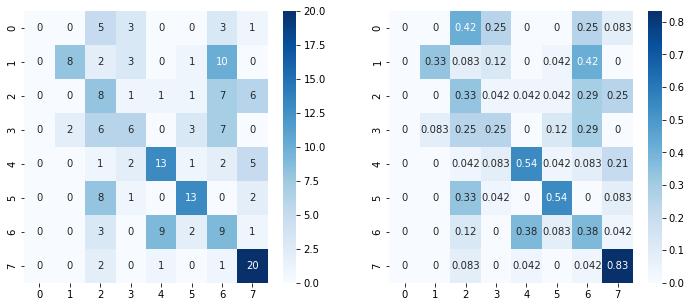

test
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        12
           1      0.800     0.333     0.471        24
           2      0.229     0.333     0.271        24
           3      0.375     0.250     0.300        24
           4      0.542     0.542     0.542        24
           5      0.619     0.542     0.578        24
           6      0.231     0.375     0.286        24
           7      0.571     0.833     0.678        24

    accuracy                          0.428       180
   macro avg      0.421     0.401     0.391       180
weighted avg      0.449     0.428     0.417       180



In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn import metrics

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    stats=metrics.classification_report(y_true, y_pred, digits=3)

    # print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm, stats

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=1, shuffle=True)
    
train_cm, train_metrics = get_confusion_matrix(mlp,train_dataloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

# print(test_cm)
true_pos = np.diag(train_cm)
train_precision = np.sum(true_pos / np.sum(train_cm, axis=0))
train_recall = np.sum(true_pos / np.sum(train_cm, axis=1))


# print(train_cm*np.eye(len(train_cm)))
val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=1, shuffle=True)
    
val_cm, val_metrics = get_confusion_matrix(mlp,val_dataloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)

# print(test_cm)
true_pos = np.diag(val_cm)
val_precision = np.sum(true_pos / np.sum(val_cm, axis=0))
val_recall = np.sum(true_pos / np.sum(val_cm, axis=1))


plot_cm(train_cm)
# print(f'Train accuracy: {train_acc}, precesion: {train_precision}, recall: {train_recall}')
print("train")
print(train_metrics)

plot_cm(val_cm)
# print(f'Val accuracy: {val_acc}, precesion: {val_precision}, recall: {val_recall}')
print("validation")
print(val_metrics)




test_iter = RAVDESSFeatureDataset(split='test',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True)
    
test_cm, test_metrics = get_confusion_matrix(mlp,test_dataloader)
# test_acc = (test_cm*np.eye(len(test_cm))).sum()/np.sum(test_cm)

# print(test_cm)
# true_pos = np.diag(test_cm)
# test_precision = np.sum(true_pos / np.sum(test_cm, axis=0))
# test_recall = np.sum(true_pos / (np.sum(test_cm, axis=1))


plot_cm(test_cm)
# print(f'Test accuracy: {test_acc}, precesion: {test_precision}, recall: {test_recall}')
print("test")
print(test_metrics)




## Train on the whole training pot

In [9]:
for p in mlp.parameters():
    if p.dim() > 1:
        nn.init.kaiming_uniform_(p)
        
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, betas=betas, eps=eps)

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": lr, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(mlp, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_deploy_epoch(mlp, optimizer)
    end_time = timer()
 
    val_loss = evaluate(mlp)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss})

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁
epoch,60
train_loss,0.57772
val_loss,0.94001


Epoch: 1, Train loss: 2.186, Epoch time = 0.980s
Epoch: 2, Train loss: 1.914, Epoch time = 0.987s
Epoch: 3, Train loss: 1.778, Epoch time = 1.014s
Epoch: 4, Train loss: 1.684, Epoch time = 1.020s
Epoch: 5, Train loss: 1.599, Epoch time = 1.030s
Epoch: 6, Train loss: 1.529, Epoch time = 1.000s
Epoch: 7, Train loss: 1.480, Epoch time = 1.035s
Epoch: 8, Train loss: 1.429, Epoch time = 1.035s
Epoch: 9, Train loss: 1.402, Epoch time = 1.008s
Epoch: 10, Train loss: 1.380, Epoch time = 1.024s
Epoch: 11, Train loss: 1.340, Epoch time = 0.985s
Epoch: 12, Train loss: 1.330, Epoch time = 1.004s
Epoch: 13, Train loss: 1.283, Epoch time = 1.021s
Epoch: 14, Train loss: 1.270, Epoch time = 1.068s
Epoch: 15, Train loss: 1.231, Epoch time = 1.078s
Epoch: 16, Train loss: 1.175, Epoch time = 1.052s
Epoch: 17, Train loss: 1.154, Epoch time = 1.076s
Epoch: 18, Train loss: 1.166, Epoch time = 1.095s
Epoch: 19, Train loss: 1.084, Epoch time = 1.082s
Epoch: 20, Train loss: 1.109, Epoch time = 1.070s
Epoch: 21

## test performance

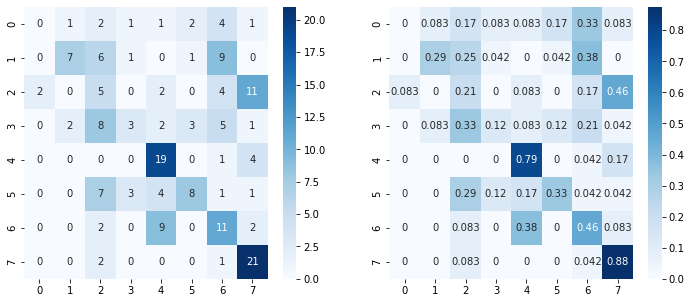

test
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        12
           1      0.700     0.292     0.412        24
           2      0.156     0.208     0.179        24
           3      0.375     0.125     0.188        24
           4      0.514     0.792     0.623        24
           5      0.571     0.333     0.421        24
           6      0.306     0.458     0.367        24
           7      0.512     0.875     0.646        24

    accuracy                          0.411       180
   macro avg      0.392     0.385     0.354       180
weighted avg      0.418     0.411     0.378       180



In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn import metrics

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    stats=metrics.classification_report(y_true, y_pred, digits=3, zero_division=0)

    # print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm, stats

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    


test_iter = RAVDESSFeatureDataset(split='test',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True)
    
test_cm, test_metrics = get_confusion_matrix(mlp,test_dataloader)
# test_acc = (test_cm*np.eye(len(test_cm))).sum()/np.sum(test_cm)

# print(test_cm)
# true_pos = np.diag(test_cm)
# test_precision = np.sum(true_pos / np.sum(test_cm, axis=0))
# test_recall = np.sum(true_pos / (np.sum(test_cm, axis=1))


plot_cm(test_cm)
# print(f'Test accuracy: {test_acc}, precesion: {test_precision}, recall: {test_recall}')
print("test")
print(test_metrics)




## 1D CNN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Ravdess_CNN_1D(nn.Module):
    def __init__(self, input_size, tgt_class_cnt, num_of_layers=None):
        super(Ravdess_CNN_1D, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        # self.hidden_dim=int(self.input_size/2)

        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel 
        self.conv1 = nn.Conv1d(1, 128, 3,stride=2, padding=0)
        
        # self.conv2 = nn.Conv1d(32, 32, 5,stride=1, padding=0)

        self.conv3 = nn.Conv1d(128, 128, 3,stride=1, padding=0)

        self.conv4 = nn.Conv1d(128, 256, 3,stride=1, padding=0)

        self.conv5 = nn.Conv1d(256, 256, 3,stride=1, padding=0)

        self.conv6 = nn.Conv1d(256, 256, 3, stride=1, padding=0)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 128)  # 5*5 from image dimension
        self.fc2 = nn.Linear(128, tgt_class_cnt)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        # x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))

        x = F.adaptive_max_pool1d(F.relu(self.conv6(x)), 1)

        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [12]:
from torchsummary import summary

INPUT_SIZE=INPUT_SIZE=imput_dim[0]*imput_dim[1]
TGT_CLASS_CNT=8
BATCH_SIZE = 64 #128

lr=0.0001
betas=(0.9, 0.98)
eps=1e-9

cnn_1d = Ravdess_CNN_1D(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(cnn_1d)

for p in cnn_1d.parameters():
    if p.dim() > 1:
        nn.init.kaiming_uniform_(p)

cnn_1d = cnn_1d.to(DEVICE)
print(cnn_1d)
# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_1d.parameters(), lr=lr, betas=betas, eps=eps)

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            512
├─Conv1d: 1-2                            49,280
├─Conv1d: 1-3                            98,560
├─Conv1d: 1-4                            196,864
├─Conv1d: 1-5                            196,864
├─Linear: 1-6                            32,896
├─Linear: 1-7                            1,032
Total params: 576,008
Trainable params: 576,008
Non-trainable params: 0
Ravdess_CNN_1D(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)


In [13]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 60
NORM=None

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.0001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(cnn_1d, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(cnn_1d, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(cnn_1d)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": [train_loss, val_loss], "val_loss": val_loss})
    

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,60
train_loss,0.56164


Epoch: 1, Train loss: 8.705, Val loss: 4.004, Epoch time = 0.590s
Epoch: 2, Train loss: 2.969, Val loss: 2.631, Epoch time = 0.578s
Epoch: 3, Train loss: 2.046, Val loss: 1.967, Epoch time = 0.588s
Epoch: 4, Train loss: 1.597, Val loss: 1.902, Epoch time = 0.586s
Epoch: 5, Train loss: 1.348, Val loss: 1.789, Epoch time = 0.589s
Epoch: 6, Train loss: 1.186, Val loss: 1.621, Epoch time = 0.595s
Epoch: 7, Train loss: 1.147, Val loss: 1.521, Epoch time = 0.583s
Epoch: 8, Train loss: 1.031, Val loss: 1.674, Epoch time = 0.567s
Epoch: 9, Train loss: 0.904, Val loss: 1.454, Epoch time = 0.567s
Epoch: 10, Train loss: 0.791, Val loss: 1.466, Epoch time = 0.552s
Epoch: 11, Train loss: 0.739, Val loss: 1.326, Epoch time = 0.561s
Epoch: 12, Train loss: 0.646, Val loss: 1.325, Epoch time = 0.559s
Epoch: 13, Train loss: 0.582, Val loss: 1.435, Epoch time = 0.565s
Epoch: 14, Train loss: 0.591, Val loss: 1.352, Epoch time = 0.582s
Epoch: 15, Train loss: 0.492, Val loss: 1.317, Epoch time = 0.573s
Epoc

## train validation performance

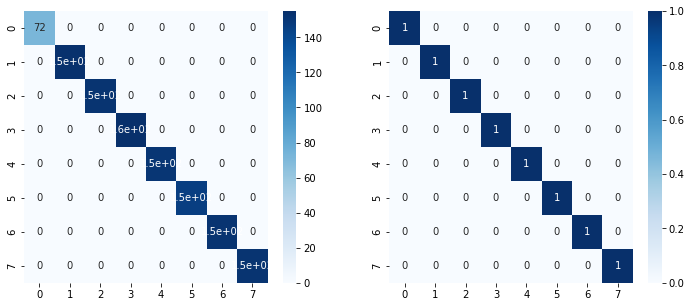

train
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        72
           1      1.000     1.000     1.000       154
           2      1.000     1.000     1.000       152
           3      1.000     1.000     1.000       155
           4      1.000     1.000     1.000       151
           5      1.000     1.000     1.000       146
           6      1.000     1.000     1.000       152
           7      1.000     1.000     1.000       152

    accuracy                          1.000      1134
   macro avg      1.000     1.000     1.000      1134
weighted avg      1.000     1.000     1.000      1134



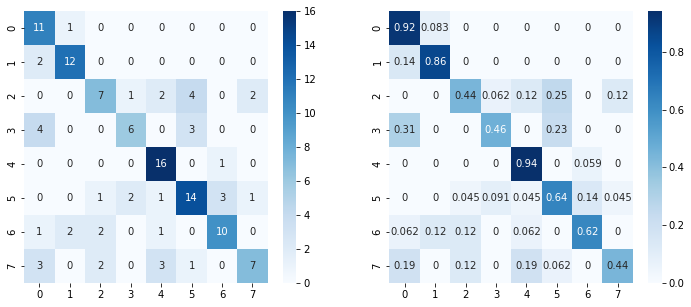

validation
              precision    recall  f1-score   support

           0      0.524     0.917     0.667        12
           1      0.800     0.857     0.828        14
           2      0.583     0.438     0.500        16
           3      0.667     0.462     0.545        13
           4      0.696     0.941     0.800        17
           5      0.636     0.636     0.636        22
           6      0.714     0.625     0.667        16
           7      0.700     0.438     0.538        16

    accuracy                          0.659       126
   macro avg      0.665     0.664     0.648       126
weighted avg      0.666     0.659     0.647       126



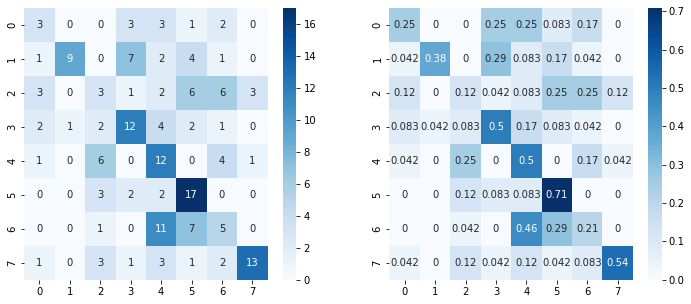

test
              precision    recall  f1-score   support

           0      0.273     0.250     0.261        12
           1      0.900     0.375     0.529        24
           2      0.167     0.125     0.143        24
           3      0.462     0.500     0.480        24
           4      0.308     0.500     0.381        24
           5      0.447     0.708     0.548        24
           6      0.238     0.208     0.222        24
           7      0.765     0.542     0.634        24

    accuracy                          0.411       180
   macro avg      0.445     0.401     0.400       180
weighted avg      0.456     0.411     0.409       180



In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn import metrics

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    stats=metrics.classification_report(y_true, y_pred, digits=3)

    # print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm, stats

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=1, shuffle=True)
    
train_cm, train_metrics = get_confusion_matrix(cnn_1d,train_dataloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

# print(test_cm)
true_pos = np.diag(train_cm)
train_precision = np.sum(true_pos / np.sum(train_cm, axis=0))
train_recall = np.sum(true_pos / np.sum(train_cm, axis=1))


# print(train_cm*np.eye(len(train_cm)))
val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=1, shuffle=True)
    
val_cm, val_metrics = get_confusion_matrix(cnn_1d,val_dataloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)

# print(test_cm)
true_pos = np.diag(val_cm)
val_precision = np.sum(true_pos / np.sum(val_cm, axis=0))
val_recall = np.sum(true_pos / np.sum(val_cm, axis=1))

plot_cm(train_cm)
# print(f'Train accuracy: {train_acc}, precesion: {train_precision}, recall: {train_recall}')
print("train")
print(train_metrics)

plot_cm(val_cm)
# print(f'Val accuracy: {val_acc}, precesion: {val_precision}, recall: {val_recall}')
print("validation")
print(val_metrics)


test_iter = RAVDESSFeatureDataset(split='test',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True)
    
test_cm, test_metrics = get_confusion_matrix(cnn_1d,test_dataloader)
# test_acc = (test_cm*np.eye(len(test_cm))).sum()/np.sum(test_cm)

# # print(test_cm)
# true_pos = np.diag(test_cm)
# test_precision = np.sum(true_pos / np.sum(test_cm, axis=0))
# test_recall = np.sum(true_pos / np.sum(test_cm, axis=1))




plot_cm(test_cm)
# print(f'Test accuracy: {test_acc}, precesion: {test_precision}, recall: {test_recall}')
print("test")
print(test_metrics)




## Train on the whole training pot

In [15]:
for p in cnn_1d.parameters():
    if p.dim() > 1:
        nn.init.kaiming_uniform_(p)
        
optimizer = torch.optim.Adam(cnn_1d.parameters(), lr=lr, betas=betas, eps=eps)

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": lr, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(cnn_1d, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_deploy_epoch(cnn_1d, optimizer)
    end_time = timer()
 
    val_loss = evaluate(cnn_1d)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss})

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▅▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁
epoch,60
val_loss,1.13625


Epoch: 1, Train loss: 9.970, Epoch time = 0.696s
Epoch: 2, Train loss: 2.650, Epoch time = 0.679s
Epoch: 3, Train loss: 1.902, Epoch time = 0.679s
Epoch: 4, Train loss: 1.512, Epoch time = 0.675s
Epoch: 5, Train loss: 1.353, Epoch time = 0.688s
Epoch: 6, Train loss: 1.328, Epoch time = 0.678s
Epoch: 7, Train loss: 1.112, Epoch time = 0.668s
Epoch: 8, Train loss: 0.978, Epoch time = 0.626s
Epoch: 9, Train loss: 0.896, Epoch time = 0.643s
Epoch: 10, Train loss: 0.777, Epoch time = 0.640s
Epoch: 11, Train loss: 0.725, Epoch time = 0.624s
Epoch: 12, Train loss: 0.762, Epoch time = 0.609s
Epoch: 13, Train loss: 0.714, Epoch time = 0.628s
Epoch: 14, Train loss: 0.593, Epoch time = 0.656s
Epoch: 15, Train loss: 0.506, Epoch time = 0.637s
Epoch: 16, Train loss: 0.434, Epoch time = 0.639s
Epoch: 17, Train loss: 0.476, Epoch time = 0.653s
Epoch: 18, Train loss: 0.418, Epoch time = 0.649s
Epoch: 19, Train loss: 0.372, Epoch time = 0.639s
Epoch: 20, Train loss: 0.312, Epoch time = 0.638s
Epoch: 21

## STest performance

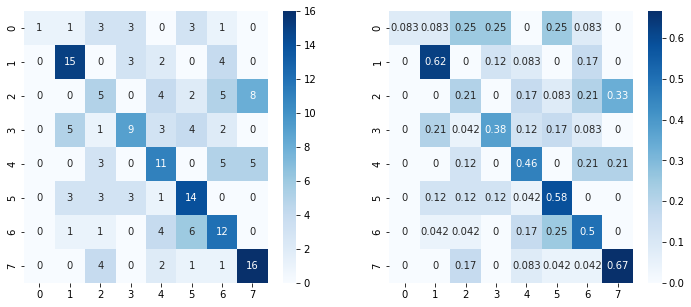

test
              precision    recall  f1-score   support

           0      1.000     0.083     0.154        12
           1      0.600     0.625     0.612        24
           2      0.250     0.208     0.227        24
           3      0.500     0.375     0.429        24
           4      0.407     0.458     0.431        24
           5      0.467     0.583     0.519        24
           6      0.400     0.500     0.444        24
           7      0.552     0.667     0.604        24

    accuracy                          0.461       180
   macro avg      0.522     0.438     0.428       180
weighted avg      0.490     0.461     0.446       180



In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn import metrics

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    stats=metrics.classification_report(y_true, y_pred, digits=3, zero_division=0)

    # print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm, stats

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    


test_iter = RAVDESSFeatureDataset(split='test',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=False)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True)
    
test_cm, test_metrics = get_confusion_matrix(cnn_1d,test_dataloader)
# test_acc = (test_cm*np.eye(len(test_cm))).sum()/np.sum(test_cm)

# # print(test_cm)
# true_pos = np.diag(test_cm)
# test_precision = np.sum(true_pos / np.sum(test_cm, axis=0))
# test_recall = np.sum(true_pos / np.sum(test_cm, axis=1))




plot_cm(test_cm)
# print(f'Test accuracy: {test_acc}, precesion: {test_precision}, recall: {test_recall}')
print("test")
print(test_metrics)


